### Variational Autoencoders

Previous example: [/examples/autoencoders/denoising.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/autoencoders/denoising.ipynb)  
Modified from: [blog.keras.io/building-autoencoders-in-keras](https://blog.keras.io/building-autoencoders-in-keras.html)  
It was the last example. [Return to the main page](https://github.com/serhatsoyer/py4ML)

In [1]:
import keras
from keras import layers
from keras.datasets import mnist
from keras import backend as ker
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [2]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
hidden = layers.Dense(intermediate_dim, activation='relu')(inputs)
hidden = layers.Dropout(1/32)(hidden)
z_mean = layers.Dense(latent_dim)(hidden)
z_log_sigma = layers.Dense(latent_dim)(hidden)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = ker.random_normal(shape=(ker.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + ker.exp(z_log_sigma) * epsilon

sample = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, sample], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
hidden = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(hidden)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

print('vae:'); vae.summary()

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

vae:
Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               50500     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               51152     
                                                                 
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


2023-01-02 16:07:51.962989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-02 16:07:51.963299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
print('encoder:'); encoder.summary()

encoder:
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           50240       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 2)            130         ['dropout[0][0]']                
                                                                                   

In [4]:
print('decoder:'); decoder.summary()

decoder:
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 dense_4 (Dense)             (None, 784)               50960     
                                                                 
Total params: 51,152
Trainable params: 51,152
Non-trainable params: 0
_________________________________________________________________


In [5]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - ker.square(z_mean) - ker.exp(z_log_sigma)
kl_loss = ker.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = ker.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [6]:
(x_train, _), (x_test, y_test) = mnist.load_data() # Labels ignored
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(f'{x_train.shape = }')
print(f'{x_test.shape = }')

x_train.shape = (60000, 784)
x_test.shape = (10000, 784)


In [7]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights=True)
vae.fit(x_train, x_train, epochs=256, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=[early_stop])

Epoch 1/256


2023-01-02 16:07:52.692578: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-02 16:07:52.984111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 256.1657

2023-01-02 16:07:55.458423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: 256.1657 - val_loss: 193.9361
Epoch 2/256
235/235 [==============================] - 2s 9ms/step - loss: 184.1316 - val_loss: 176.7287
Epoch 3/256
235/235 [==============================] - 2s 8ms/step - loss: 173.6251 - val_loss: 169.9057
Epoch 4/256
235/235 [==============================] - 2s 8ms/step - loss: 169.2399 - val_loss: 167.7522
Epoch 5/256
235/235 [==============================] - 2s 8ms/step - loss: 167.4104 - val_loss: 166.4697
Epoch 6/256
235/235 [==============================] - 2s 8ms/step - loss: 166.2367 - val_loss: 165.6435
Epoch 7/256
235/235 [==============================] - 2s 8ms/step - loss: 165.1390 - val_loss: 164.6077
Epoch 8/256
235/235 [==============================] - 2s 8ms/step - loss: 164.0543 - val_loss: 163.5674
Epoch 9/256
235/235 [==============================] - 2s 9ms/step - loss: 163.0088 - val_loss: 162.6372
Epoch 10/256
235/235 [==============================] - 2s 8ms/ste

2023-01-02 16:10:47.597668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


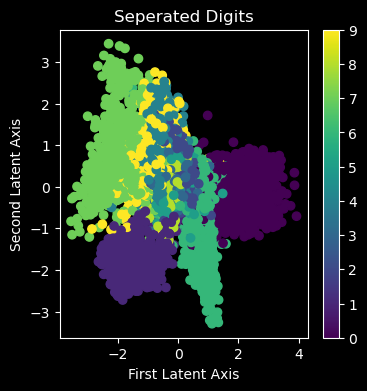

In [8]:
encoded_imgs = encoder.predict(x_test, verbose=0)
plt.style.use('dark_background')
plt.figure(figsize=(4, 4))
plt.scatter(encoded_imgs[2][:, 0], encoded_imgs[2][:, 1], c=y_test)
plt.colorbar()
plt.xlabel('First Latent Axis')
plt.ylabel('Second Latent Axis')
plt.title('Seperated Digits')
plt.show()

2023-01-02 16:10:48.340420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


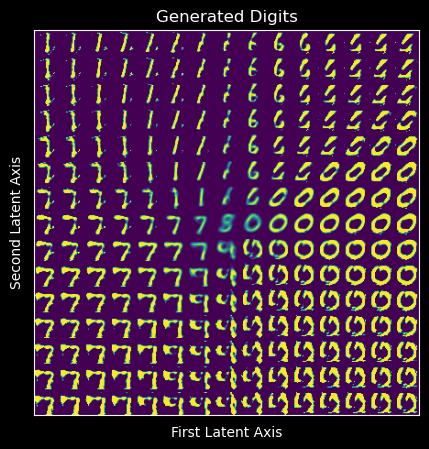

In [9]:
# Display a 2D manifold of the digits
num_of_digits_to_display = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * num_of_digits_to_display, digit_size * num_of_digits_to_display))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, num_of_digits_to_display)
grid_y = np.linspace(-15, 15, num_of_digits_to_display)
for idx, yi in enumerate(grid_x):
    for jdx, xi in enumerate(grid_y):
        x_decoded = decoder.predict(np.array([[xi, yi]]), verbose=0)
        figure[idx * digit_size: (idx + 1) * digit_size, jdx * digit_size: (jdx + 1) * digit_size] = x_decoded[0].reshape(digit_size, digit_size)

plt.style.use('dark_background')
plt.figure(figsize=(5, 5))
plt.imshow(figure)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('First Latent Axis')
plt.ylabel('Second Latent Axis')
plt.title('Generated Digits')
plt.show()

Previous example: [/examples/autoencoders/denoising.ipynb](https://github.com/serhatsoyer/py4ML/blob/main/examples/autoencoders/denoising.ipynb)  
Modified from: [blog.keras.io/building-autoencoders-in-keras](https://blog.keras.io/building-autoencoders-in-keras.html)  
It was the last example. [Return to the main page](https://github.com/serhatsoyer/py4ML)